## Import Libraries

In [1]:
#import libraries

%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import scikitplot.plotters as skplt
import scikitplot as skpltcm
import nltk

## Read the train data from the Files 

In [2]:
df_train_txt = pd.read_csv('./data/training_text', sep='\|\|', engine='python', header=None, skiprows=1, names=["ID","Text"])
df_train_txt.head()
df_train_var = pd.read_csv('./data/training_variants')
df_train_var.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


## Clean up the Dirty data or data which cannot be used for training 
 Removed all the data which is null since Classification depends on the text.
 If text is not available then the data cannot be used for training.

In [3]:
df_train_txt = df_train_txt[~df_train_txt['Text'].isnull()]
df_train_var =df_train_var[df_train_var.ID.isin(df_train_txt.ID)]

## Encode the Gene and Variation field 
Also tried to Fit the values to 1  
The encoding is required since ML runs only on the numeric fields

In [4]:
#Converting text into numeric values using lable encoder
#Conveting gene to numeric and making sure the value is less than or equal to 1

gene_le = LabelEncoder()
gene_encoded = gene_le.fit_transform(df_train_var['Gene'].values.ravel()).reshape(-1, 1)
gene_encoded = gene_encoded / np.max(gene_encoded)
df_train_var["gene_encoded"] = gene_encoded

#Conveting Variation to numeric and making sure the value is less than or equal to 1

variation_le = LabelEncoder()
variation_encoded = gene_le.fit_transform(df_train_var['Variation'].values.ravel()).reshape(-1, 1)
variation_encoded = variation_encoded / np.max(variation_encoded)
df_train_var["variation_encoded"] = variation_encoded
df_train_var.head()

,ID,Gene,Variation,Class,gene_encoded,variation_encoded
0,0,FAM58A,Truncating Mutations,1,0.321839,0.877674
1,1,CBL,W802*,2,0.145594,0.953543
2,2,CBL,Q249E,2,0.145594,0.633356
3,3,CBL,N454D,3,0.145594,0.556484
4,4,CBL,L399V,4,0.145594,0.482955


## This is to check how the output values of train data are looking before even evaluating

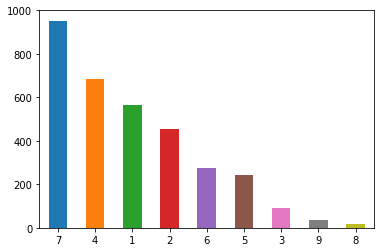

In [5]:
df_train_var['Class'].value_counts().plot(kind="bar", rot=0)

This shows the class are not distrubed properly


## Extract the features by using TFID Vectorization
This will be helpful to extract feature set from the paragraph 

In [23]:
count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=250)    

tfidf = count_vectorizer.fit_transform(df_train_txt['Text'])
len(count_vectorizer.get_feature_names())


250

## Feature set reduction using  truncated singular value decomposition
This is used in order to run on the local machine increasing the feature set is taking lot of time

In [7]:
#reducing to 50 key words using Truncated SVD 
svd = TruncatedSVD(n_components=50, n_iter=200, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

In [8]:
print("reduced number of feature set")
len(truncated_tfidf[0])

reduced number of feature set


50

## This is common code for evaluating the log loss and accuracy
Utilizing the built in feature for identifying the best the split of train data using Cross validation
This is also used for printing the Confusion matrix

In [9]:
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    from sklearn.linear_model import LogisticRegression
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skpltcm.metrics.plot_confusion_matrix(y, preds)
    #skplt.metrics.plot_confusion_matrix

## Using Random forest to clasify the details based on the features extracted

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished


Log loss: 1.6804037962673433
Accuracy: 0.3751507840772014


C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


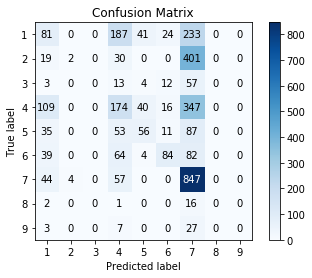

In [10]:
evaluate_features(np.hstack((gene_encoded, variation_encoded, truncated_tfidf,cvdetails)), df_train_var['Class'],
                  RandomForestClassifier(n_estimators=100, max_depth=5, verbose=1))

## Random forest classifier with modified estimators for better accuracy

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.1s finished
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 2.0057367686048955
Accuracy: 0.35705669481302776


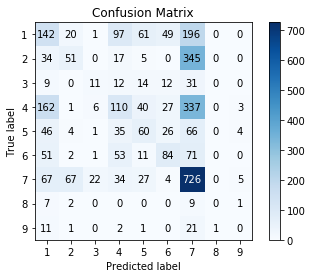

In [11]:
evaluate_features( truncated_tfidf, df_train_var['Class'],
                  RandomForestClassifier(n_estimators=1000, max_depth=15, verbose=1))

## Check with  Logistic regression Algorithm whether this algo suits

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 1.6494479721008892
Accuracy: 0.4092279855247286


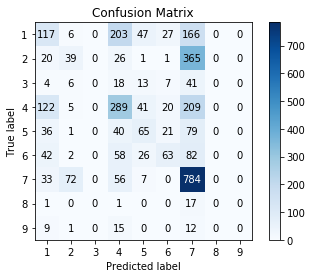

In [12]:
from sklearn.linear_model import LogisticRegression
evaluate_features(np.hstack((gene_encoded, variation_encoded, truncated_tfidf)), df_train_var['Class'])

## Check with  SVC Linear Algorithm whether this algo suits and accuracy is improved

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 1.7996254502494557
Accuracy: 0.3721351025331725


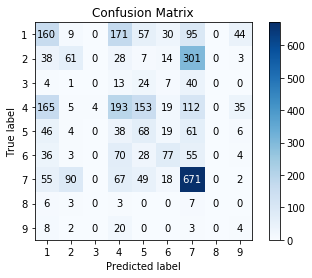

In [13]:
evaluate_features(np.hstack((gene_encoded, variation_encoded, truncated_tfidf)), df_train_var['Class'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   48.2s finished
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 1.7895383035875736
Accuracy: 0.37002412545235225


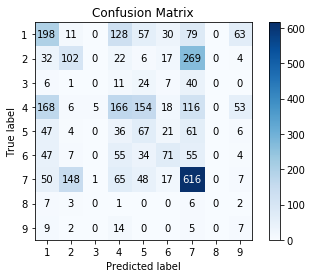

In [20]:
evaluate_features(tfidf, df_train_var['Class'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

## Using one hot techinque to check for better accuracy with truncation

In [14]:
one_hot_gene = pd.get_dummies(df_train_var['Gene'])
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)

In [15]:
one_hot_variation = pd.get_dummies(df_train_var['Variation'])
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)

## Checking with Random forest with one hot techinque

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished


Log loss: 1.7128066888791842
Accuracy: 0.3558504221954162


C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


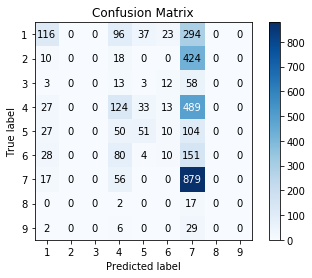

In [16]:
evaluate_features(np.hstack((truncated_one_hot_gene, truncated_one_hot_variation, truncated_tfidf)), df_train_var['Class'],
                  RandomForestClassifier(n_estimators=100, max_depth=5, verbose=1))

## Checking with Random forest with one hot techinque with max Depth to 10

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 1.7187637662536286
Accuracy: 0.3854041013268999


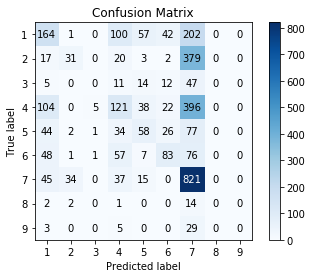

In [17]:
evaluate_features(np.hstack((truncated_one_hot_gene, truncated_one_hot_variation, truncated_tfidf)), df_train_var['Class'],
                  RandomForestClassifier(n_estimators=100, max_depth=10, verbose=1))

##  Checking with Random forest with one hot techinque with Entropy 

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished


Log loss: 1.7269941858013342
Accuracy: 0.3676115802171291


C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


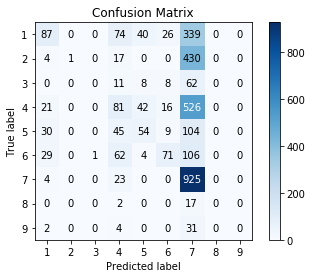

In [18]:
evaluate_features(np.hstack((truncated_one_hot_gene, truncated_one_hot_variation, truncated_tfidf)), df_train_var['Class'],
                  RandomForestClassifier(n_estimators=100, max_depth=5, verbose=1,criterion = 'entropy'))

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 1.6494479721008892
Accuracy: 0.4092279855247286


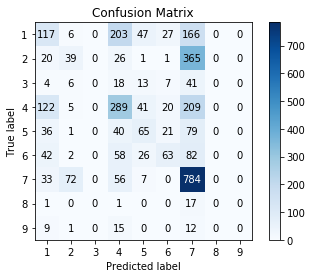

In [19]:
from sklearn.linear_model import LogisticRegression
evaluate_features(np.hstack((gene_encoded, variation_encoded, truncated_tfidf)), df_train_var['Class'])

JoblibAttributeError: JoblibAttributeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x0000000C62AF6660, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\rajesh.nv\AppData\Local\Continuum\anaco...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\r...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000000C62AF6660, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\rajesh.nv\AppData\Local\Continuum\anaco...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\r...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(820, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\asyncio\events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(820, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (820, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\platform\asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=820, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "from sklearn import svm\nevaluate_features(np.hst...d_tfidf)), df_train_var['Class'],svm.LinearSVC())", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 7, 31, 9, 46, 6, 401724, tzinfo=tzutc()), 'msg_id': '24571ec2f2a14f8bb3ea1a94a173c27c', 'msg_type': 'execute_request', 'session': '42436dfd99b044f0b3c8c3cadd2245c2', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '24571ec2f2a14f8bb3ea1a94a173c27c', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'42436dfd99b044f0b3c8c3cadd2245c2']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "from sklearn import svm\nevaluate_features(np.hst...d_tfidf)), df_train_var['Class'],svm.LinearSVC())", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 7, 31, 9, 46, 6, 401724, tzinfo=tzutc()), 'msg_id': '24571ec2f2a14f8bb3ea1a94a173c27c', 'msg_type': 'execute_request', 'session': '42436dfd99b044f0b3c8c3cadd2245c2', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '24571ec2f2a14f8bb3ea1a94a173c27c', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'42436dfd99b044f0b3c8c3cadd2245c2'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "from sklearn import svm\nevaluate_features(np.hst...d_tfidf)), df_train_var['Class'],svm.LinearSVC())", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 7, 31, 9, 46, 6, 401724, tzinfo=tzutc()), 'msg_id': '24571ec2f2a14f8bb3ea1a94a173c27c', 'msg_type': 'execute_request', 'session': '42436dfd99b044f0b3c8c3cadd2245c2', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '24571ec2f2a14f8bb3ea1a94a173c27c', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="from sklearn import svm\nevaluate_features(np.hst...d_tfidf)), df_train_var['Class'],svm.LinearSVC())", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "from sklearn import svm\nevaluate_features(np.hst...d_tfidf)), df_train_var['Class'],svm.LinearSVC())"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("from sklearn import svm\nevaluate_features(np.hst...d_tfidf)), df_train_var['Class'],svm.LinearSVC())",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("from sklearn import svm\nevaluate_features(np.hst...d_tfidf)), df_train_var['Class'],svm.LinearSVC())",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="from sklearn import svm\nevaluate_features(np.hst...d_tfidf)), df_train_var['Class'],svm.LinearSVC())", store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = "from sklearn import svm\nevaluate_features(np.hst...d_tfidf)), df_train_var['Class'],svm.LinearSVC())"
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="from sklearn import svm\nevaluate_features(np.hst...d_tfidf)), df_train_var['Class'],svm.LinearSVC())", store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Expr object>], cell_name='<ipython-input-26-0199166088bb>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at c07493208, execution_...rue silent=False shell_futures=True> result=None>)
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])
   2908                 code = compiler(mod, cell_name, "single")
-> 2909                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000000C06DF1660, file "<ipython-input-26-0199166088bb>", line 2>
        result = <ExecutionResult object at c07493208, execution_...rue silent=False shell_futures=True> result=None>
   2910                     return True
   2911 
   2912             # Flush softspace
   2913             if softspace(sys.stdout, 0):

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000000C06DF1660, file "<ipython-input-26-0199166088bb>", line 2>, result=<ExecutionResult object at c07493208, execution_...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000000C06DF1660, file "<ipython-input-26-0199166088bb>", line 2>
        self.user_global_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'In': ['', '#import libraries\n\nget_ipython().run_line_magic(...as skplt\nimport scikitplot as skpltcm\nimport nltk', "df_train_txt = pd.read_csv('./data/training_text...v('./data/training_variants')\ndf_train_var.head()", "df_train_txt = df_train_txt[~df_train_txt['Text'..._train_var[df_train_var.ID.isin(df_train_txt.ID)]", '#Converting text into numeric values using lable...encoded"] = variation_encoded\ndf_train_var.head()', 'df_train_var[\'Class\'].value_counts().plot(kind="bar", rot=0)', "count_vectorizer = TfidfVectorizer(\n    analyzer...Text'])\nlen(count_vectorizer.get_feature_names())", '#reducing to 50 key words using Truncated SVD \ns...te=12)\ntruncated_tfidf = svd.fit_transform(tfidf)', 'print("reduced number of feature set")\nlen(truncated_tfidf[0])', 'def evaluate_features(X, y, clf=None):\n    """Ge..., preds)\n    #skplt.metrics.plot_confusion_matrix', 'evaluate_features(np.hstack((gene_encoded, varia...sifier(n_estimators=100, max_depth=5, verbose=1))', 'evaluate_features( truncated_tfidf, df_train_var...fier(n_estimators=1000, max_depth=15, verbose=1))', "from sklearn.linear_model import LogisticRegress...ncoded, truncated_tfidf)), df_train_var['Class'])", "evaluate_features(np.hstack((gene_encoded, varia...          SVC(kernel='linear', probability=True))", "one_hot_gene = pd.get_dummies(df_train_var['Gene...hot_gene = svd.fit_transform(one_hot_gene.values)", 'one_hot_variation = pd.get_dummies(df_train_var[...ion = svd.fit_transform(one_hot_variation.values)', 'evaluate_features(np.hstack((truncated_one_hot_g...sifier(n_estimators=100, max_depth=5, verbose=1))', 'evaluate_features(np.hstack((truncated_one_hot_g...ifier(n_estimators=100, max_depth=10, verbose=1))', "evaluate_features(np.hstack((truncated_one_hot_g...0, max_depth=5, verbose=1,criterion = 'entropy'))", "from sklearn.linear_model import LogisticRegress...ncoded, truncated_tfidf)), df_train_var['Class'])", ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {2:    ID    Gene             Variation  Class
0   0...     3
4   4     CBL                 L399V      4, 4:    ID    Gene             Variation  Class  gene...    L399V      4      0.145594           0.482955, 5: <matplotlib.axes._subplots.AxesSubplot object>, 6: 250, 8: 50, 23: 250}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'TfidfVectorizer': <class 'sklearn.feature_extraction.text.TfidfVectorizer'>, 'TruncatedSVD': <class 'sklearn.decomposition.truncated_svd.TruncatedSVD'>, ...}
        self.user_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'In': ['', '#import libraries\n\nget_ipython().run_line_magic(...as skplt\nimport scikitplot as skpltcm\nimport nltk', "df_train_txt = pd.read_csv('./data/training_text...v('./data/training_variants')\ndf_train_var.head()", "df_train_txt = df_train_txt[~df_train_txt['Text'..._train_var[df_train_var.ID.isin(df_train_txt.ID)]", '#Converting text into numeric values using lable...encoded"] = variation_encoded\ndf_train_var.head()', 'df_train_var[\'Class\'].value_counts().plot(kind="bar", rot=0)', "count_vectorizer = TfidfVectorizer(\n    analyzer...Text'])\nlen(count_vectorizer.get_feature_names())", '#reducing to 50 key words using Truncated SVD \ns...te=12)\ntruncated_tfidf = svd.fit_transform(tfidf)', 'print("reduced number of feature set")\nlen(truncated_tfidf[0])', 'def evaluate_features(X, y, clf=None):\n    """Ge..., preds)\n    #skplt.metrics.plot_confusion_matrix', 'evaluate_features(np.hstack((gene_encoded, varia...sifier(n_estimators=100, max_depth=5, verbose=1))', 'evaluate_features( truncated_tfidf, df_train_var...fier(n_estimators=1000, max_depth=15, verbose=1))', "from sklearn.linear_model import LogisticRegress...ncoded, truncated_tfidf)), df_train_var['Class'])", "evaluate_features(np.hstack((gene_encoded, varia...          SVC(kernel='linear', probability=True))", "one_hot_gene = pd.get_dummies(df_train_var['Gene...hot_gene = svd.fit_transform(one_hot_gene.values)", 'one_hot_variation = pd.get_dummies(df_train_var[...ion = svd.fit_transform(one_hot_variation.values)', 'evaluate_features(np.hstack((truncated_one_hot_g...sifier(n_estimators=100, max_depth=5, verbose=1))', 'evaluate_features(np.hstack((truncated_one_hot_g...ifier(n_estimators=100, max_depth=10, verbose=1))', "evaluate_features(np.hstack((truncated_one_hot_g...0, max_depth=5, verbose=1,criterion = 'entropy'))", "from sklearn.linear_model import LogisticRegress...ncoded, truncated_tfidf)), df_train_var['Class'])", ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {2:    ID    Gene             Variation  Class
0   0...     3
4   4     CBL                 L399V      4, 4:    ID    Gene             Variation  Class  gene...    L399V      4      0.145594           0.482955, 5: <matplotlib.axes._subplots.AxesSubplot object>, 6: 250, 8: 50, 23: 250}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'TfidfVectorizer': <class 'sklearn.feature_extraction.text.TfidfVectorizer'>, 'TruncatedSVD': <class 'sklearn.decomposition.truncated_svd.TruncatedSVD'>, ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
D:\Projects\AI_ML\Assignment\<ipython-input-26-0199166088bb> in <module>()
      1 from sklearn import svm
----> 2 evaluate_features(np.hstack((gene_encoded, variation_encoded, truncated_tfidf)), df_train_var['Class'],svm.LinearSVC())

...........................................................................
D:\Projects\AI_ML\Assignment\<ipython-input-9-0db1a609cf34> in evaluate_features(X=array([[ 0.32183908,  0.8776738 ,  0.96385203, .... -0.0137718 ,
         0.0168018 , -0.01010067]]), y=0       1
1       2
2       2
3       3
4       ...3320    4
Name: Class, Length: 3316, dtype: int64, clf=LinearSVC(C=1.0, class_weight=None, dual=True, f...', random_state=None, tol=0.0001,
     verbose=0))
     13     from sklearn.linear_model import LogisticRegression
     14     if clf is None:
     15         clf = LogisticRegression()
     16     
     17     probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
---> 18                               n_jobs=-1, method='predict_proba', verbose=2)
     19     pred_indices = np.argmax(probas, axis=1)
     20     classes = np.unique(y)
     21     preds = classes[pred_indices]
     22     print('Log loss: {}'.format(log_loss(y, probas)))

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in cross_val_predict(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, f...', random_state=None, tol=0.0001,
     verbose=0), X=array([[ 0.32183908,  0.8776738 ,  0.96385203, .... -0.0137718 ,
         0.0168018 , -0.01010067]]), y=array([0, 1, 1, ..., 0, 3, 3], dtype=int64), groups=None, cv=StratifiedKFold(n_splits=3, random_state=8, shuffle=False), n_jobs=-1, verbose=2, fit_params=None, pre_dispatch='2*n_jobs', method='predict_proba')
    675     # independent, and that it is pickle-able.
    676     parallel = Parallel(n_jobs=n_jobs, verbose=verbose,
    677                         pre_dispatch=pre_dispatch)
    678     prediction_blocks = parallel(delayed(_fit_and_predict)(
    679         clone(estimator), X, y, train, test, verbose, fit_params, method)
--> 680         for train, test in cv.split(X, y, groups))
        cv.split = <bound method StratifiedKFold.split of StratifiedKFold(n_splits=3, random_state=8, shuffle=False)>
        X = array([[ 0.32183908,  0.8776738 ,  0.96385203, .... -0.0137718 ,
         0.0168018 , -0.01010067]])
        y = array([0, 1, 1, ..., 0, 3, 3], dtype=int64)
        groups = None
    681 
    682     # Concatenate the predictions
    683     predictions = [pred_block_i for pred_block_i, _ in prediction_blocks]
    684     test_indices = np.concatenate([indices_i

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object cross_val_predict.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
AttributeError                                     Tue Jul 31 15:16:08 2018
PID: 2960Python 3.6.5: C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\python.exe
...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_predict>, (LinearSVC(C=1.0, class_weight=None, dual=True, f...', random_state=None, tol=0.0001,
     verbose=0), memmap([[ 0.32183908,  0.8776738 ,  0.96385203, ...-0.0137718 ,
          0.0168018 , -0.01010067]]), array([0, 1, 1, ..., 0, 3, 3], dtype=int64), array([ 135,  136,  512, ..., 3313, 3314, 3315]), array([   0,    1,    2, ..., 2031, 2036, 2050]), 2, None, 'predict_proba'), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_predict>
        args = (LinearSVC(C=1.0, class_weight=None, dual=True, f...', random_state=None, tol=0.0001,
     verbose=0), memmap([[ 0.32183908,  0.8776738 ,  0.96385203, ...-0.0137718 ,
          0.0168018 , -0.01010067]]), array([0, 1, 1, ..., 0, 3, 3], dtype=int64), array([ 135,  136,  512, ..., 3313, 3314, 3315]), array([   0,    1,    2, ..., 2031, 2036, 2050]), 2, None, 'predict_proba')
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\rajesh.nv\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_predict(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, f...', random_state=None, tol=0.0001,
     verbose=0), X=memmap([[ 0.32183908,  0.8776738 ,  0.96385203, ...-0.0137718 ,
          0.0168018 , -0.01010067]]), y=array([0, 1, 1, ..., 0, 3, 3], dtype=int64), train=array([ 135,  136,  512, ..., 3313, 3314, 3315]), test=array([   0,    1,    2, ..., 2031, 2036, 2050]), verbose=2, fit_params={}, method='predict_proba')
    749 
    750     if y_train is None:
    751         estimator.fit(X_train, **fit_params)
    752     else:
    753         estimator.fit(X_train, y_train, **fit_params)
--> 754     func = getattr(estimator, method)
        func = undefined
        estimator = LinearSVC(C=1.0, class_weight=None, dual=True, f...', random_state=None, tol=0.0001,
     verbose=0)
        method = 'predict_proba'
    755     predictions = func(X_test)
    756     if method in ['decision_function', 'predict_proba', 'predict_log_proba']:
    757         n_classes = len(set(y))
    758         if n_classes != len(estimator.classes_):

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'
___________________________________________________________________________